In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(0)
import os
print("Tensorflow Version:",tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import datetime
!rm -rf ./logs/ 


In [2]:
import tensorflow as tf
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.8.241.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.241.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [3]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Load and Explore NER Dataset

Essential info about tagged entitites:
  * geo = Geographic Entity
  * org = Organisation
  * per = Person
  * gpe = Geopolitical Entity
  * tim = Time Indicator
  * art = Artifact
  * eve = Event
  * nat = Natural Phenomenon
  


In [ ]:
data = pd.read_csv('/content/sample_data/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(10)

In [ ]:
data.nunique()

In [ ]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)
num_words


In [ ]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
num_tags

## Retrive Sentences and Corresponding Tags

In [ ]:
#w - word, p - pos, t-tag
class SentenceGetter(object):
  def __init__(self, data):
    self.num_sentences = 1
    self.data = data
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
                                                       
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentences = [s for s in self.grouped]



In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

## Define Mappings Between Sentences and Tags

In [ ]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2word = {value: key for key, value in word2idx.items()}

## Padding Input Sentences and Creating Train/Test Split

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxlen = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = maxlen, sequences = X, padding = 'post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = maxlen, sequences = y, padding = 'post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
def model():
    input_word = Input(shape=(maxlen, ))
    model = Embedding(input_dim=num_words, output_dim=maxlen, input_length=maxlen)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
    model = Model(input_word, out)
    return model
model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
with strategy.scope():
  model = model()
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [21]:
checkpoint_filepath = '/content/model_weights_2.h5'
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                   save_weights_only = True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_best_only = True)
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              patience = 3, 
                              verbose = 0, 
                              mode='max', 
                              restore_best_weights=False)

callbacks = [model_checkpoint, earlystopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    callbacks = callbacks,
    epochs = 10
)

Epoch 1/10
  1/960 [..............................] - ETA: 3s - loss: 0.0450 - accuracy: 0.9856WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0028s vs `on_train_batch_end` time: 0.0200s). Check your callbacks.


958/960 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9882WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_test_batch_end` time: 0.0096s). Check your callbacks.


960/960 [==============================] - 24s 25ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.0491 - val_accuracy: 0.9852
Epoch 2/10
960/960 [==============================] - 24s 26ms/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0504 - val_accuracy: 0.9849
Epoch 3/10
960/960 [==============================] - 24s 25ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0502 - val_accuracy: 0.9855
Epoch 4/10
960/960 [==============================] - 24s 25ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.0508 - val_accuracy: 0.9859
Epoch 5/10
960/960 [==============================] - 24s 25ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0543 - val_accuracy: 0.9851
Epoch 6/10
960/960 [==============================] - 24s 25ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0573 - val_accuracy: 0.9848
Epoch 7/10
960/960 [==============================] - 24s 25ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0591 - val_accuracy: 0.9850


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


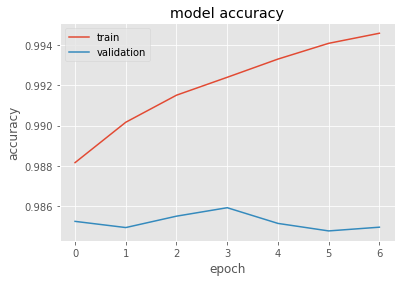

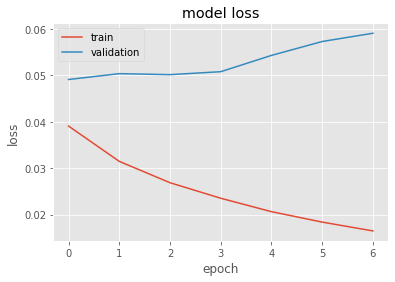

In [24]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
model.evaluate(X_test, np.array(y_test))

  1/300 [..............................] - ETA: 10s - loss: 0.0453 - accuracy: 0.9862WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0141s). Check your callbacks.


300/300 [==============================] - 6s 18ms/step - loss: 0.0624 - accuracy: 0.9847


[0.062380772083997726, 0.9847269058227539]

In [36]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis =-1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Prediction"))
print("--"*15)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{:5}\t {}\n".format(words[w-1], tags[true], tags[pred]))


Word           True 	 Prediction

------------------------------
Elsewhere      O    	 O

,              O    	 O

the            O    	 O

Asian          B-org	 B-org

Development    I-org	 I-org

Bank           I-org	 I-org

has            O    	 O

announced      O    	 O

a              O    	 O

$              O    	 O

30             O    	 O

million        O    	 O

grant          O    	 O

for            O    	 O

Vietnam        B-geo	 B-geo

,              O    	 O

Cambodia       B-geo	 B-geo

and            O    	 O

Laos           B-geo	 B-geo

to             O    	 O

help           O    	 O

contain        O    	 O

the            O    	 O

spread         O    	 O

of             O    	 O

bird           O    	 O

flu            O    	 O

and            O    	 O

other          O    	 O

diseases       O    	 O

.              O    	 O

directly       O    	 O

directly       O    	 O

directly       O    	 O

directly       O    	 O

directly       O    	 O

directly   